This notebook runs the list-learning behavioral analyses

## Import libraries

In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import quail
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

from sherlock_helpers.constants import DATA_DIR, FIG_DIR, HAND_REC

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Set plot parameters

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
palette = 'bone'

## Filter some harmless warnings

In [3]:
# pandas.DataFrame.get_values() was deprecated for container's pandas version
filterwarnings('ignore', "The 'get_values' method is deprecated", FutureWarning, module='quail.analysis.recmat')
# averaging across lags for lag-CRP where all are nans
filterwarnings('ignore', "Mean of empty slice", RuntimeWarning, module='quail.analysis')
# seaborn.JointGrid stat annotation was deprecated for container's seaborn version.
filterwarnings('ignore', "JointGrid annotation is deprecated", UserWarning, module='seaborn.axisgrid')

## Load data

In [4]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'))
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)

## Convert to egg format

In [5]:
pres = [[[{'item' : i, 'topics' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
    rec.append([[{'item' : item, 'topics' : t} for item, t in zip(items, r)]])

## Make the egg

In [6]:
egg = quail.Egg(pres=pres, rec=rec)
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 30
Date created: Thu Aug 13 22:21:24 2020
Meta data: {}


## Run probability of first recall, lagcrp and serial position curve analyses, and create a figure

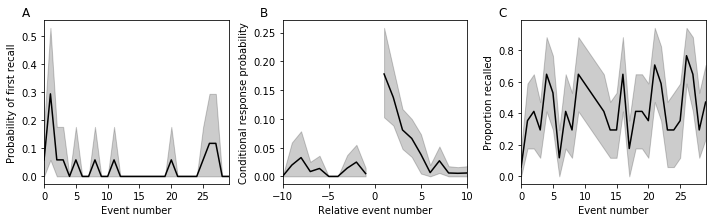

In [7]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

analysis = ['pfr', 'lagcrp', 'spc']
res = {}
for ax, a in zip(axarr, analysis):
    res[a] = egg.analyze(a, match='best', features=['topics'], 
                distance='correlation')
    res[a].plot(show=False, ax=ax, legend=False, palette=palette)
        
# make some adjustments
axarr[0].set_xlabel('Event number')
axarr[0].set_ylabel('Probability of first recall')

axarr[1].set_xlim(-10, 10)
axarr[1].set_xlabel('Relative event number')
axarr[1].set_ylabel('Conditional response probability')

axarr[2].set_xlabel('Event number')
axarr[2].set_ylabel('Proportion recalled')

plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()

# add labels
label=['A', 'B', 'C']
for ax, l in zip(axarr, label):
    ax.text(-.1, 1.025, 
           l,
           horizontalalignment='center',
           transform=ax.transAxes,
           fontsize=12)
# plt.savefig(FIG_DIR.joinpath('list_learning.pdf'), bbox_inches='tight')
plt.show()

## Cluster analyses

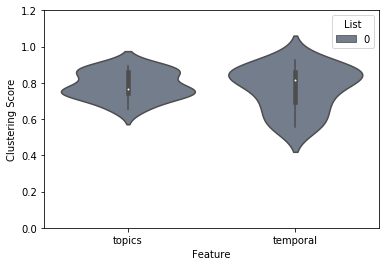

In [8]:
clustering = egg.analyze('fingerprint')
clustering.plot(ylim=[0, 1.2], palette=palette)
plt.show()

## SEM of clustering scores

In [9]:
sem = clustering.get_data().std() / np.sqrt(17)
print('Mean clustering score:\n', clustering.get_data().mean(), end='\n\n')
print('SEM:\n', sem, end='\n\n')
print('Mean + SEM:\n', clustering.get_data().mean() + sem, end='\n\n')
print('Mean - SEM:\n', clustering.get_data().mean() - sem)

Mean clustering score:
 topics      0.786880
temporal    0.766666
dtype: float64

SEM:
 topics      0.017989
temporal    0.029183
dtype: float64

Mean + SEM:
 topics      0.804868
temporal    0.795849
dtype: float64

Mean - SEM:
 topics      0.768891
temporal    0.737483
dtype: float64


## Create a dataframe containing the analysis results

In [10]:
df = pd.DataFrame({
    'Temporal clustering': clustering.data.temporal.values,
    'Semantic clustering': clustering.data.topics.values,
    'Number of events (k)': [r.shape[0] for r in recall_events],
    'Memory performance - hand': HAND_REC,
    'Memory performance - auto': res['spc'].data.mean(axis=1).values
})

In [11]:
jointplot_kwargs = {
    'data': df,
    'kind': 'reg',
    'stat_func': pearsonr,
    'space': 0,
    'color': 'k'
}

## Correlation between hand annotated memory and memory estimated from the model across subjects

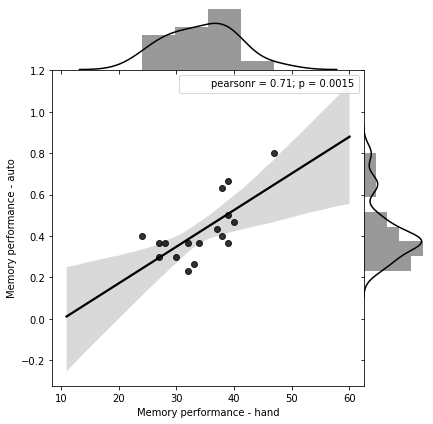

In [12]:
sns.jointplot(x='Memory performance - hand', 
              y='Memory performance - auto', 
              **jointplot_kwargs)
plt.show()

## Correlation between hand annotated memory and k (number of events) across subjects

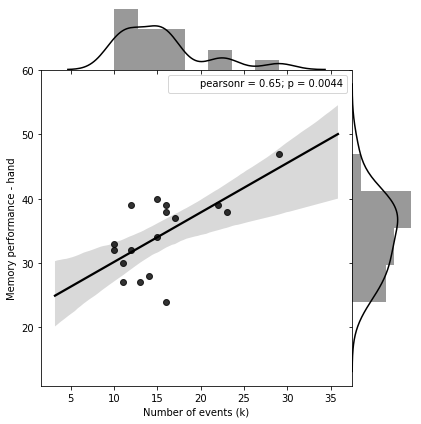

In [13]:
sns.jointplot(x='Number of events (k)', 
              y='Memory performance - hand', 
              **jointplot_kwargs)
plt.show()

## Correlation between hand annotated memory and temporal clustering

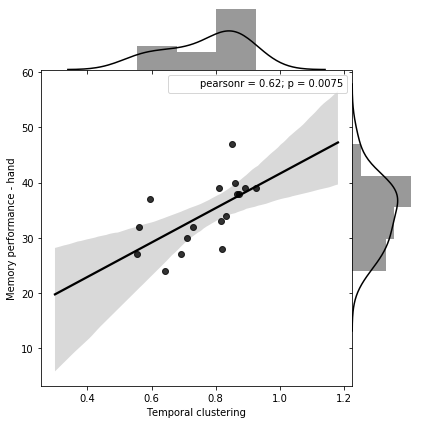

In [14]:
sns.jointplot(x='Temporal clustering', 
              y='Memory performance - hand', 
              **jointplot_kwargs)
plt.show()

## Correlation between model-estimated memory and temporal clustering

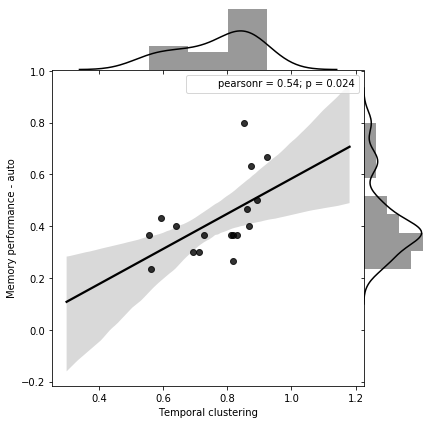

In [15]:
sns.jointplot(x='Temporal clustering', 
              y='Memory performance - auto', 
              **jointplot_kwargs)
plt.show()

## Correlation between k (number of events) and temporal clustering

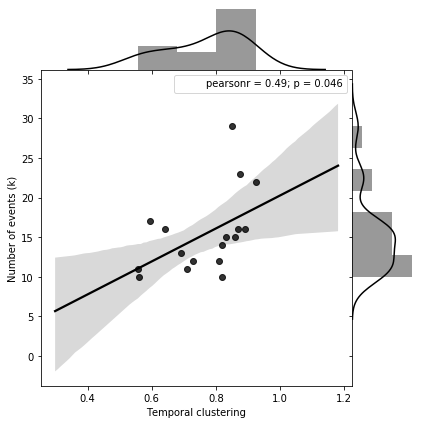

In [16]:
sns.jointplot(x='Temporal clustering', 
              y='Number of events (k)', 
              **jointplot_kwargs)
plt.show()

## Correlation between hand annotated memory and semantic clustering

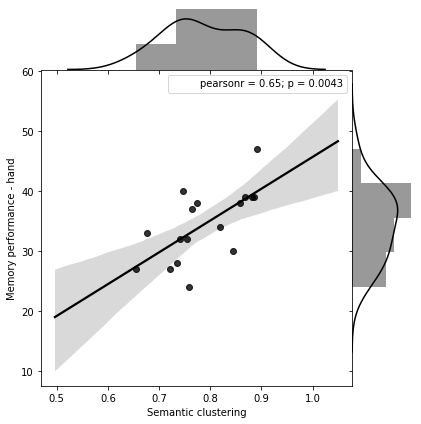

In [17]:
sns.jointplot(x='Semantic clustering', 
              y='Memory performance - hand', 
              **jointplot_kwargs)
plt.show()

## Correlation between model-estimated memory and semantic clustering

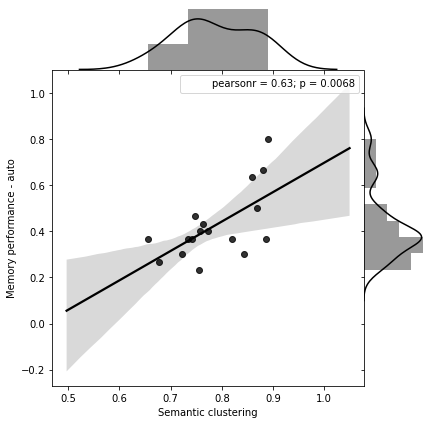

In [18]:
sns.jointplot(x='Semantic clustering', 
              y='Memory performance - auto', 
              **jointplot_kwargs)
plt.show()

## Correlation between k (number of events) and semantic clustering

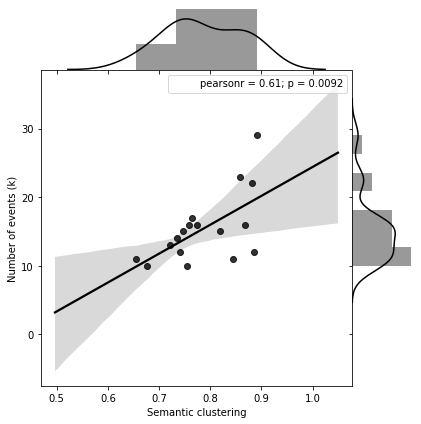

In [19]:
sns.jointplot(x='Semantic clustering', 
              y='Number of events (k)', 
              **jointplot_kwargs)
plt.show()